# Importar dados HTML 

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import folium

sns.set()

importar dados html usando o BeautifulSoup

In [2]:
# URL to be imported
url = 'https://www.csn.uchile.cl/sismologia/grandes-terremotos-en-chile/'
# Open a URL request
r = requests.get(url)
# Get HTML text
html_doc = r.text
# Create a BeautifulSoup object to extract HTML data using Tags
soup = BeautifulSoup(html_doc)

Existe apenas uma tabela HTML nesta URL e queremos transformá-la em um DataFrame. Em HTML, tr significa “linha da tabela”, th significa “cabeçalho da tabela” e td significa “dados da tabela”, que é onde os dados são armazenados como texto. A solução apresentada aqui é desta postagem do blog.

In [3]:
# Implement a loop to fill table's rows
rows = []
# Not all tables have a tbody tag, but this one does. Otherwise, use table attribute.
for child in soup.tbody.children:
    row = []
    for td in child:
        try:
            # Convert new lines to empty space
            row.append(td.text.replace('\n', '')) 
        except:
            continue
    if len(row) > 0:
        rows.append(row)
        
df = pd.DataFrame(rows[1:], columns=rows[0])

Vamos dar uma olhada em nossa mesa.

In [4]:
df.head()

,,Fecha local,,Hora local,,Latitud,,Longitud,,Magnitud Ms,,Magnitud Mw,,Profundidad [km],,Efecto,
0,,08/02/1570,,9:00,,-36.800,,-73.000,,8.3,,-,,-,,TD,
1,,17/03/1575,,10:00,,-33.400,,-70.600,,7.3,,-,,-,,-,
2,,16/12/1575,,14:30,,-39.800,,-73.200,,8.5,,-,,-,,TD,
3,,24/11/1604,,12:30,,-18.500,,-70.400,,8.5,,-,,30,,TD,
4,,16/09/1615,,23:30,,-18.500,,-70.350,,8.8,,-,,-,,TM,


In [5]:
df.tail()

,,Fecha local,,Hora local,,Latitud,,Longitud,,Magnitud Ms,,Magnitud Mw,,Profundidad [km],,Efecto,
108,,14/11/2007,,12:40,,-22.314,,-70.078,,7.5,,7.7,,47.7,,-,
109,,27/02/2010,,03:34,,-36.290,,-73.239,,-,,8.8,,30,,TD,
110,,01/04/2014,,20:46,,-19-572,,-70.908,,-,,8.2,,38.9,,T,
111,,16/09/2015,,19:54,,-31.553,,-71.864,,-,,8.4,,11.1,,TD,
112,,25/12/2016,,11:22,,-43.517,,-74.391,,-,,7.6,,30,,T,


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0                     113 non-null    object
 1   Fecha local       113 non-null    object
 2                     113 non-null    object
 3   Hora local        113 non-null    object
 4                     113 non-null    object
 5   Latitud           113 non-null    object
 6                     113 non-null    object
 7   Longitud          113 non-null    object
 8                     113 non-null    object
 9   Magnitud Ms       113 non-null    object
 10                    113 non-null    object
 11  Magnitud Mw       113 non-null    object
 12                    113 non-null    object
 13  Profundidad [km]  113 non-null    object
 14                    113 non-null    object
 15  Efecto            113 non-null    object
 16                    113 non-null    object
dtypes: object(17)
me

# Limpando os dados

Gostaríamos de converter as datas do terremoto para data e hora, mas o intervalo de datas está fora do limite. O intervalo máximo permitido por datetime é de 584 anos, conforme pode ser visto abaixo. Porém, o primeiro terremoto da lista é do ano de 1570! Portanto, trabalharemos com datas de forma mais explícita.

In [7]:
pd.Timestamp.min, pd.Timestamp.max

(Timestamp('1677-09-21 00:12:43.145224193'),
 Timestamp('2262-04-11 23:47:16.854775807'))

Primeiro extraímos explicitamente o dia, mês e ano.

In [8]:
# Extracting day, month and year 
date = df["Fecha local"].values
day, month, year = [[my_str.split("/")[i] for my_str in date] for i in range(3)]
df["year"] = year
df["month"]= month
df["day"] = day

Vamos renomear as colunas para inglês por conveniência e converter valores vazios - para valores NaN e Magnitud com, para. sinal decimal.

In [9]:
#df_clean = df.replace({",":".", "-$": np.nan}, regex=True).apply(pd.to_numeric, errors='ignore')
#cols = ['date', 'time', 'latitude', 'longitude', 'mag_ms', 'mag_mw', 'depth_km', 'effect', 'year', 'month', 'day'] 
#df_clean.columns = cols
#df_clean.head()
df_clean = df.replace({",":".", "-$": np.nan}, regex=True).apply(pd.to_numeric, errors='ignore')
df_clean = df_clean.dropna(axis=1, how="all")
df_clean = df_clean.rename(columns={"Fecha local": "date", "Hora local": "time", "Latitud": "latitude", "Longitud": "longitude", "Magnitud Ms": "mag_ms", "Magnitud Mw": "mag_mw", "Profundidad [km]": "depth_km", "Efecto": "effect"})
colunalatitude = df_clean["latitude"]
colunalatitude = colunalatitude.str.replace(',', '.')
colunalatitude = pd.to_numeric(colunalatitude, errors='coerce')
df_clean["latitude"] = colunalatitude
df_clean.head()

,date,time,latitude,longitude,mag_ms,mag_mw,depth_km,effect,year,month,day
0,08/02/1570,9:00,-36.8,-73.00,8.3,NaN,NaN,TD,1570,2,8
1,17/03/1575,10:00,-33.4,-70.60,7.3,NaN,NaN,NaN,1575,3,17
2,16/12/1575,14:30,-39.8,-73.20,8.5,NaN,NaN,TD,1575,12,16
3,24/11/1604,12:30,-18.5,-70.40,8.5,NaN,30.0,TD,1604,11,24
4,16/09/1615,23:30,-18.5,-70.35,8.8,NaN,NaN,TM,1615,9,16


In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       113 non-null    object 
 1   time       110 non-null    object 
 2   latitude   112 non-null    float64
 3   longitude  113 non-null    float64
 4   mag_ms     108 non-null    float64
 5   mag_mw     13 non-null     float64
 6   depth_km   61 non-null     float64
 7   effect     34 non-null     object 
 8   year       113 non-null    int64  
 9   month      113 non-null    int64  
 10  day        113 non-null    int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 9.8+ KB


# Analyzing the Data Dados

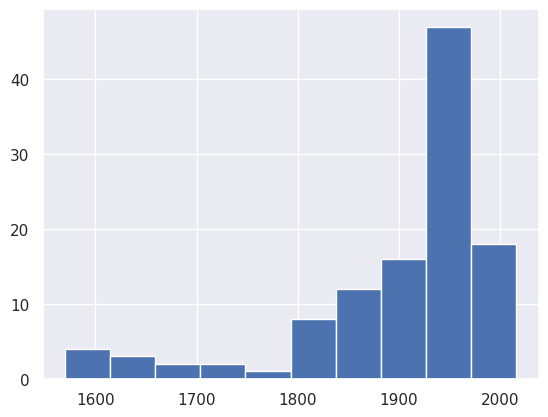

In [11]:
df = df_clean.copy()
nbins = int(np.sqrt(len(df)))
df['year'].hist(bins=nbins)
plt.show()

Neste gráfico, vemos que a maioria dos acontecimentos foi registrada na década de 1900. Isto é esperado, uma vez que os sismógrafos se tornaram mais difundidos no século XX. Portanto, a seguir, analisaremos apenas os acontecimentos posteriores ao ano de 1900.

Observe que há uma queda no número de eventos mais próximos do ano 2000. Vamos verificar mais de perto os eventos do século passado para ver o que está acontecendo.

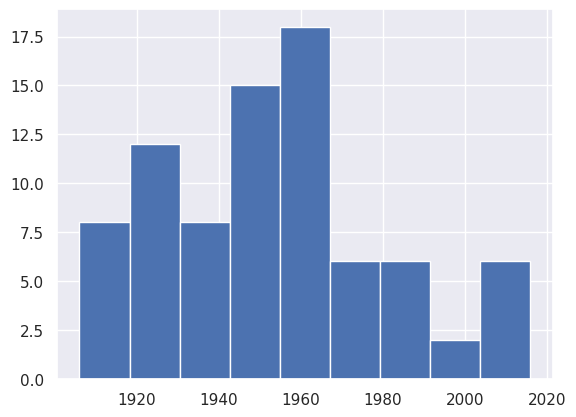

In [12]:
df1900 = df[df['year'] >= 1900]
nbins = int(np.sqrt(len(df1900)))
df1900['year'].hist(bins=nbins)
plt.show()

Vemos uma queda importante no número de grandes eventos depois de 1970. Não está claro por que isso acontece e talvez seja necessária uma análise mais refinada da fenomenologia dos terremotos para entender o que está acontecendo. No entanto, sabemos que um grande número de eventos aleatórios raros segue uma distribuição de Poisson. Seria esse o caso aqui?

Qual é o número médio de terremotos por ano registrado?

In [13]:
df1900['year'].value_counts().mean()

1.4464285714285714

Temos um grande número de eventos aparentemente raros, pois ocorrem menos de 2 eventos por ano e alguns anos não tiveram eventos de grande porte. Portanto, precisamos incluir os anos que não tiveram grandes eventos para fazer uma análise adequada.

Primeiro, criamos uma tabela com todos os anos de 1906 a 2020.

In [14]:
years = pd.DataFrame({'year' : range(min(df1900['year']), max(df1900['year'])+1)})
years.head()

,year
0,1906
1,1907
2,1908
3,1909
4,1910


Depois contamos o número de eventos por ano e fundimos esta tabela com a tabela com todos os anos.

In [15]:
event_count = df1900.value_counts('year').sort_index()
df_count = pd.DataFrame({'year': event_count.index, 'events' : event_count.values})
events_per_year = years.merge(df_count, on='year', how='left').replace(np.nan,0).astype(int).set_index('year')
events_per_year.head()

,events
year,
1906,1
1907,0
1908,0
1909,1
1910,1


In [16]:
avg_events_year = events_per_year.mean().iloc[0] #Ajuste para futuras versões do pandas
avg_events_year

0.7297297297297297

Podemos agora verificar a proporção de anos entre 1906 e 2020 que não tiveram grandes eventos:

In [17]:
(100*events_per_year[events_per_year.events == 0].count()/len(events_per_year)).iloc[0]

49.549549549549546

Isso é aproximadamente 50%, sugerindo que grandes eventos acontecem aleatoriamente ao longo dos anos. Agora vamos verificar a distribuição observada do número de eventos.

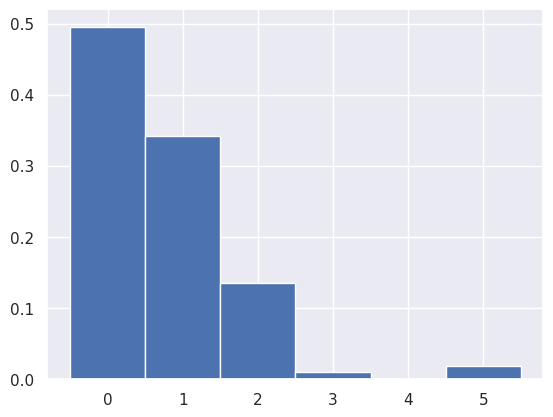

In [18]:
bins = np.arange(0, max(events_per_year.events) + 1.5) - 0.5
plt.hist(events_per_year, density=True, bins=bins)
plt.show()

Queremos comparar isto com uma distribuição de Poisson com uma média de 0,71 eventos por ano.

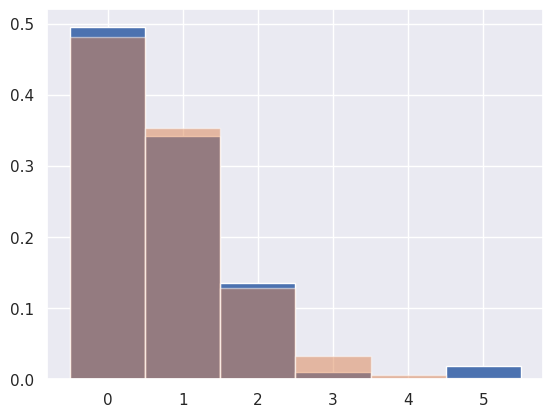

In [19]:
poisson = np.random.poisson(avg_events_year, 100000)

plt.hist(events_per_year, density=True, bins=bins)
plt.hist(poisson, density=True, bins=bins, alpha=0.5)

plt.show()

Isso parece muito semelhante! Podemos ver a correspondência mais detalhadamente com uma função de distribuição cumulativa empírica (ECDF), utilizando a função definida abaixo.

In [20]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

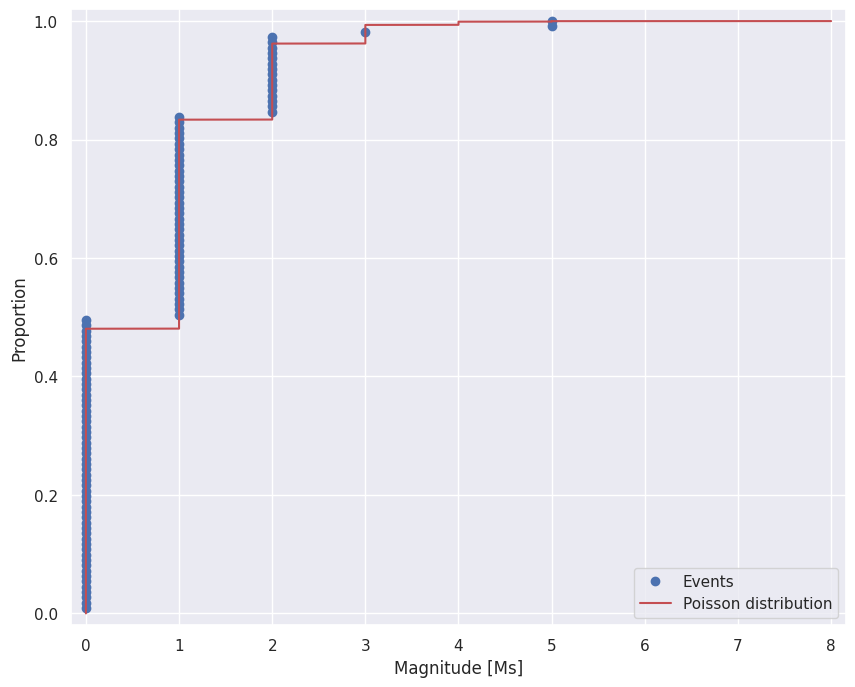

In [21]:
plt.figure(figsize=(10,8))

x, y = ecdf(events_per_year['events'])
xnb, ynb = ecdf(poisson)

plt.plot(x, y, 'bo', label='Events')
plt.plot(xnb, ynb, 'r-', label='Poisson distribution')
plt.xlabel('Magnitude [Ms]')
plt.ylabel('Proportion')

plt.legend()
plt.margins(0.02) # Keeps data off plot edges
plt.show()

O ajuste é bastante bom e a pequena incompatibilidade deve ser devida ao pequeno número de eventos registrados.

Agora vamos verificar a distribuição dos eventos por mês.

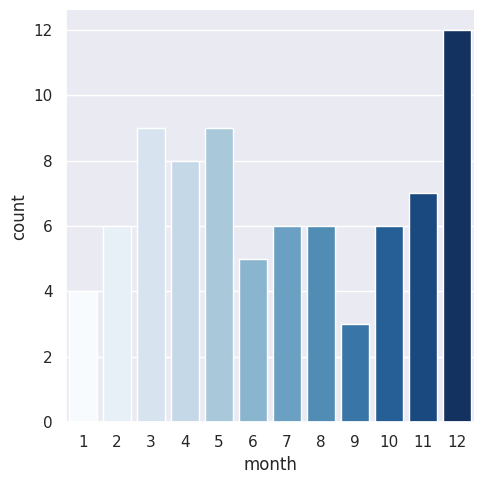

In [22]:
events_per_month = df1900.sort_values('month')
sns.catplot(x='month', hue='month', data=events_per_month, kind='count', palette='Blues', legend=False)
plt.show()

aqui está uma quantidade maior de grandes terremotos em dezembro. Como sabemos se isso é estatisticamente significativo? Podemos fazer um teste de hipótese. Suponhamos que os terremotos aconteçam aleatoriamente ao longo dos meses do ano. Qual é a probabilidade de obter os valores observados? Para testar isso, criaremos um grande número de amostras aleatórias de bootstrap a partir de nossos dados mensais e analisaremos a distribuição de eventos.

Antes de fazer isso, vamos verificar o quão próximo está o CDF dos eventos de um evento uniformemente aleatório.

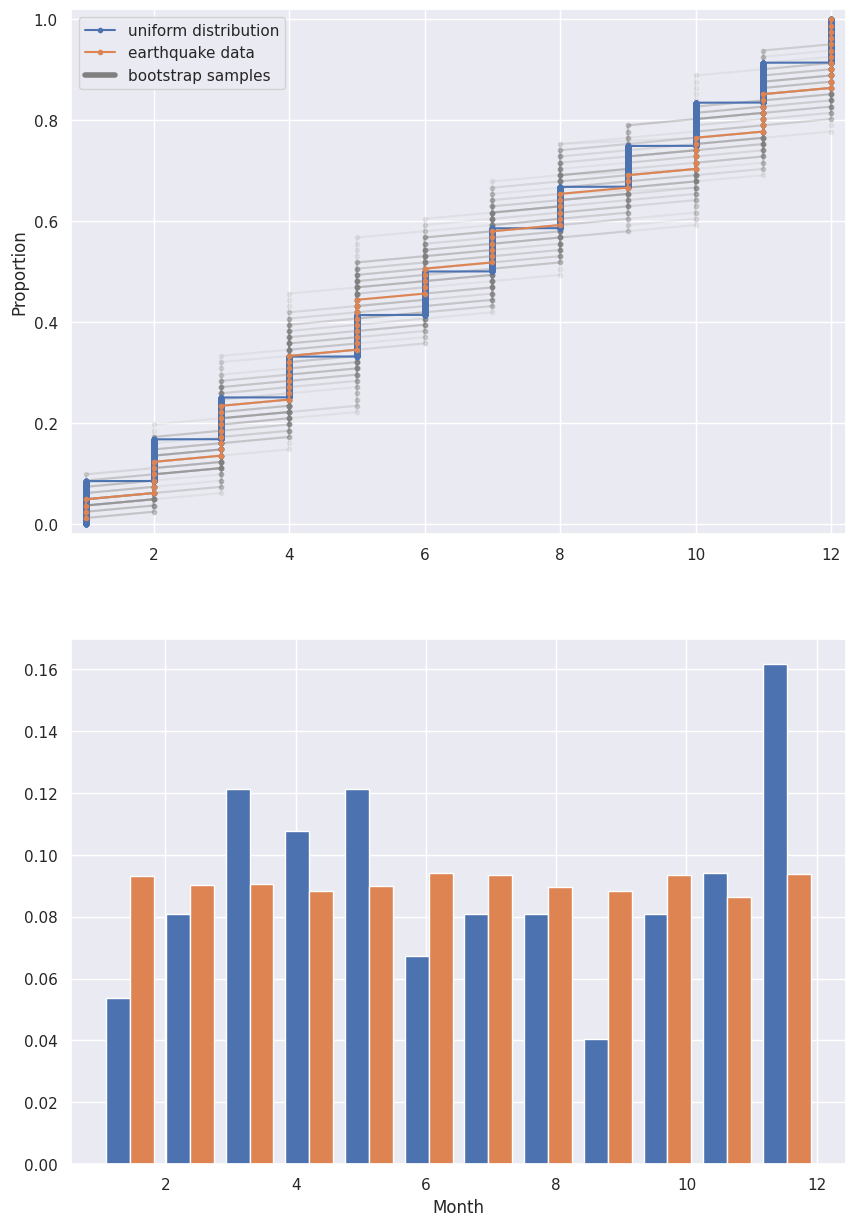

In [23]:
fig, ax = plt.subplots(nrows=2, figsize=(10,15))

for _ in range(50):
    # Generate bootstrap sample: bs_sample
    bs_sample = np.random.choice(events_per_month.month.values, size=len(events_per_month.month.values))

    # Compute and plot ECDF from bootstrap sample
    x, y = ecdf(bs_sample)
    _ = ax[0].plot(x, y, marker='.',
                 color='gray', alpha=0.1)

# Seed the random number generator
np.random.seed(42)

# Generate random numbers between 1 and 12 by looping over range(100000)
size = 10000 #len(events_per_month)
random_numbers = np.random.randint(1,13,size)

# Compute and plot ECDF from original data
x, y = ecdf(random_numbers)
line1, = ax[0].plot(x, y, marker='.', label='uniform distribution')

# Compute and plot ECDF from original data
x, y = ecdf(events_per_month.month)
line2, = ax[0].plot(x, y, marker='.', label='earthquake data')

ax[1].hist([events_per_month.month, random_numbers], density=True, bins=12)

# Make margins and label axes
ax[0].margins(0.02)
ax[0].set(ylabel='Proportion')
ax[1].set(xlabel='Month')

# Make legends
legend_elements = [line1, line2, Line2D([0], [0], color='grey', lw=4, label='bootstrap samples')]
ax[0].legend(handles=legend_elements, loc='upper left')


# Show the plot
plt.show()

Essas distribuições parecem bastante semelhantes, dado o pequeno número de eventos sísmicos. Também plotamos amostras de bootstrap em cinza para ver a variabilidade da escolha aleatória dos dados com substituição. A distribuição aleatória está dentro do nosso nível de variabilidade. Agora, faremos nosso teste de hipótese para ver quão próxima está a distribuição mensal de eventos de uma distribuição uniforme.

Testando hipóteses
Nossa hipótese nula aqui é que a distribuição de terremotos por mês é uniformemente aleatória. Para testar esta suposição, usaremos a diferença entre a variância das distribuições como nossa estatística de teste e geraremos um grande número de valores a partir de amostras bootstrap. Isso será realizado pelas seguintes etapas:

Combine os dados empíricos com dados uniformemente distribuídos do mesmo tamanho.
Permute os dados combinados com substituição e gere duas novas amostras. Este é um exemplo de bootstrap.
Repita o processo um grande número de vezes e calcule a estatística de teste para cada amostra. Este é um conjunto de réplicas de bootstrap.
Trace um histograma do conjunto e calcule o valor p de nossa estatística de teste original.
Se o valor p for pequeno, a variância das duas distribuições é estatisticamente significativamente diferente. Caso contrário, não podemos descartar a hipótese nula.

Começamos definindo algumas funções personalizadas para nossa tarefa.

In [24]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

def diff_of_mean(data_1, data_2):
      """Difference in variance of two arrays."""
  
      # The difference of means of data_1, data_2: diff
      diff = np.mean(data_1) - np.mean(data_2)
  
      return diff

def diff_of_var(data_1, data_2):
      """Difference in variance of two arrays."""
  
      # The difference of means of data_1, data_2: diff
      diff = np.var(data_1) - np.var(data_2)
  
      return diff

Geramos a distribuição aleatória uniforme random_numbers e calculamos um conjunto de réplicas de bootstrap bs_replicates de tamanho 10.000.

In [25]:
bs_replicates = draw_perm_reps(events_per_month.month, random_numbers, diff_of_var, 10000)

Vamos verificar a diferença da média entre os dados e os números aleatórios

In [26]:
diff_of_mean(events_per_month.month, random_numbers)

0.26903209876543155

e a diferença de variâncias é

In [27]:
diff_of_var(events_per_month.month, random_numbers)

0.7731686374881885

Agora podemos traçar a distribuição da diferença de variâncias no conjunto e comparar com o valor acima.

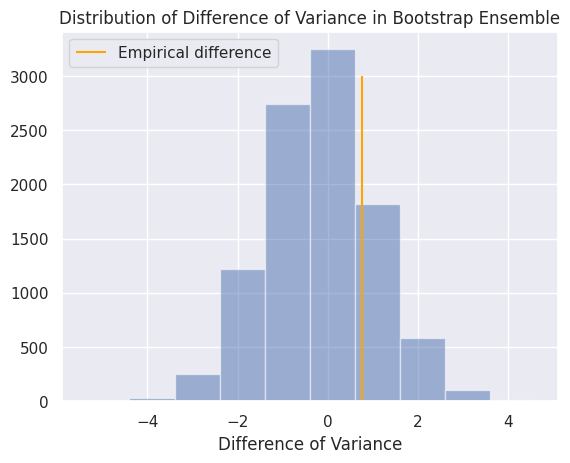

p-value = 0.2108


In [28]:
plt.hist(bs_replicates, alpha=0.5)
plt.vlines(x=diff_of_var(events_per_month.month.values, random_numbers),\
           ymin=0,ymax=3000, label='Empirical difference', color='orange')
plt.xlabel('Difference of Variance')
plt.title('Distribution of Difference of Variance in Bootstrap Ensemble')
plt.legend(loc='upper left')
plt.show()

# Computing the p-value
p = np.sum(bs_replicates >= diff_of_var(events_per_month.month.values, random_numbers)) / len(bs_replicates)
print('p-value =', p)

Vemos que o valor p é bastante elevado, sugerindo que não podemos descartar a hipótese nula, ou seja, que a distribuição mensal dos terremotos é aproximadamente uniforme.

# Distribuições das magnitudes dos terremotos no tempo e no espaço
Vamos calcular o ECDF da magnitude Ms.

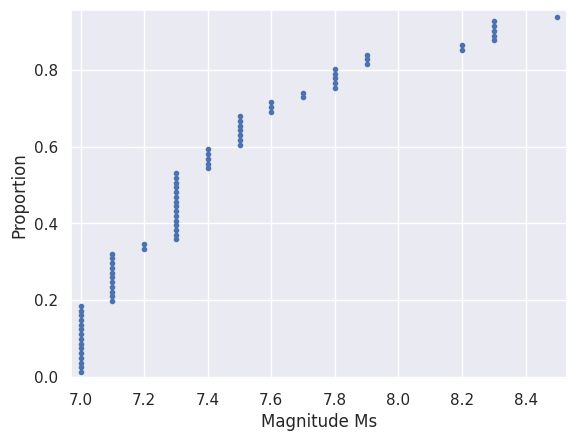

In [29]:
x, y = ecdf(df1900['mag_ms'])
plt.plot(x, y, '.')
plt.xlabel('Magnitude Ms')
plt.ylabel('Proportion')
plt.margins(0.02) # Keeps data off plot edges
plt.show()

A partir disso, vemos que cerca de 60% dos grandes terremotos tiveram magnitude Ms inferior ou igual a 7,4 e apenas 20% dos eventos tiveram magnitude superior a 7,8. Podemos ver isso com mais detalhes com um histograma:

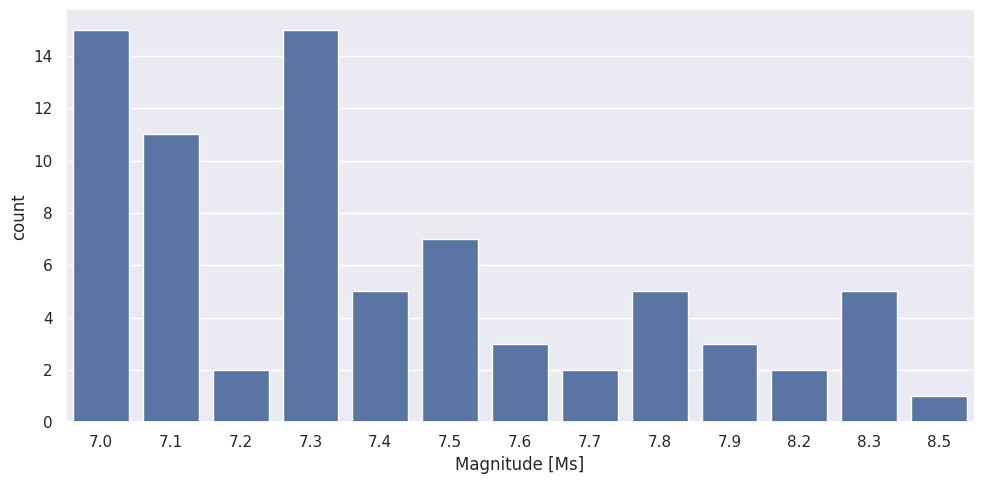

In [30]:
magnitud_ms = df1900[~df1900['mag_ms'].isna()].sort_values('mag_ms')

g1 = sns.catplot(x='mag_ms',data=magnitud_ms, kind='count', aspect=2)
g1.set(xlabel='Magnitude [Ms]')
plt.show()

Também podemos verificar a distribuição de magnitude por mês com um boxplot.

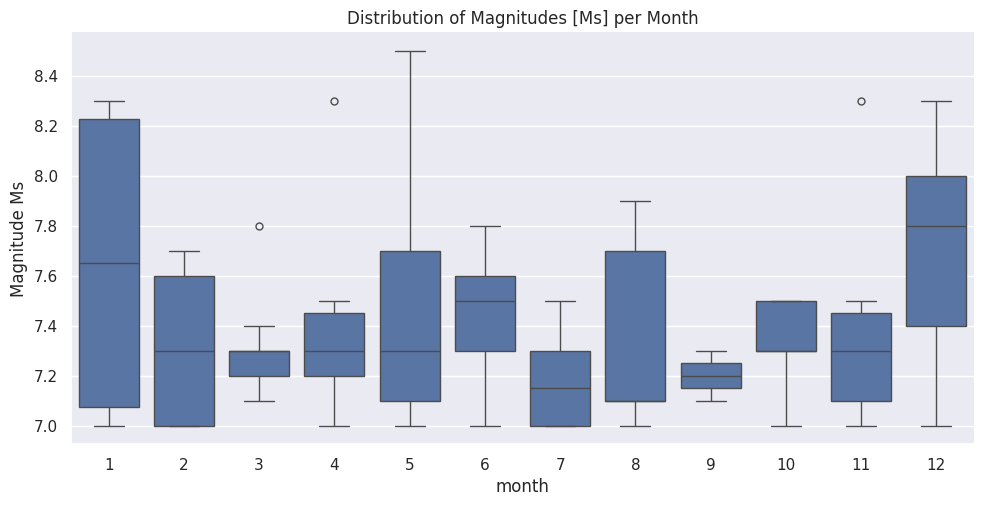

In [31]:
g = sns.catplot(x='month', y='mag_ms', data=magnitud_ms, kind='box', aspect=2)
g.set(ylabel='Magnitude Ms', title='Distribution of Magnitudes [Ms] per Month')
plt.show()

existe uma grande variabilidade em relação aos diferentes meses, mas isso provavelmente se deve ao pequeno número de eventos.

Vemos alguma tendência nas magnitudes do evento no tempo? Podemos testar isso por meio de um gráfico de regressão linear.

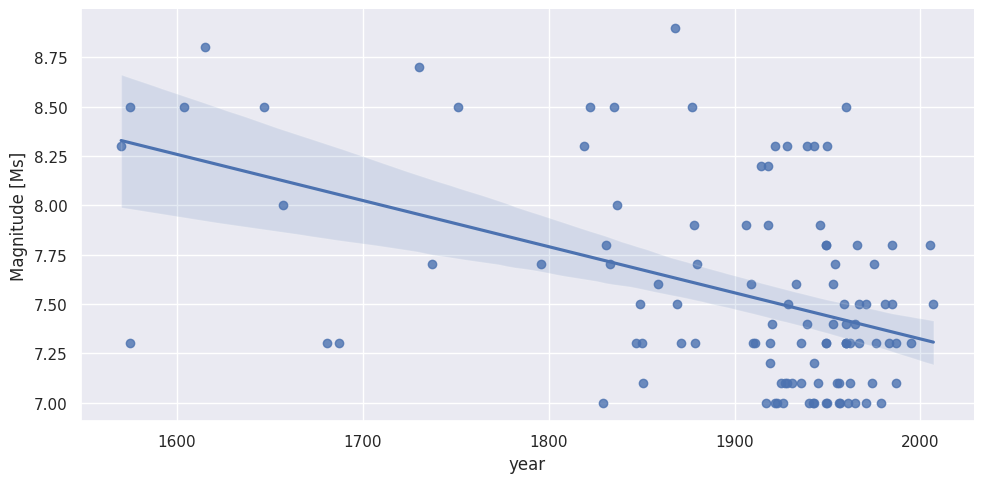

In [32]:
g1 = sns.lmplot(y='mag_ms', x='year', data=df, aspect=2)
g1.set(ylabel='Magnitude [Ms]')

plt.show()

Há uma inclinação significativa, mas incluímos os acontecimentos anteriores a 1900. Estes dados não são fiáveis e são muito esparsos, como pode ser visto acima. Se nos restringirmos aos acontecimentos posteriores a 1900, a tendência é muito menos proeminente.

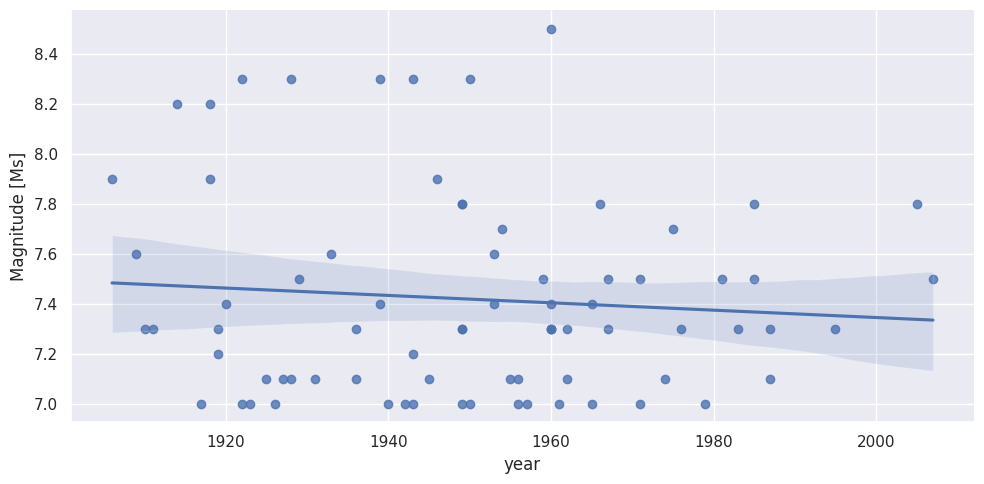

In [33]:
g1 = sns.lmplot(y='mag_ms', x='year', data=magnitud_ms, aspect=2)
g1.set(ylabel='Magnitude [Ms]')

plt.show()

Agora vemos apenas um ligeiro declínio na magnitude média. Vamos verificar o coeficiente de correlação de Pearson de magnitude e ano.

In [34]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    # Compute correlation matrix: corr_mat
    corr_mat = np.corrcoef(x, y)

    # Return entry [0,1]
    return corr_mat[0,1]

In [35]:
pearson_r(magnitud_ms['year'].values,magnitud_ms['mag_ms'].values)

-0.08767702495520914

Os valores são pequenos, sugerindo que não há forte correlação negativa entre magnitude e ano.

Também podemos dar uma olhada na distribuição espacial das magnitudes com um gráfico de dispersão simples.

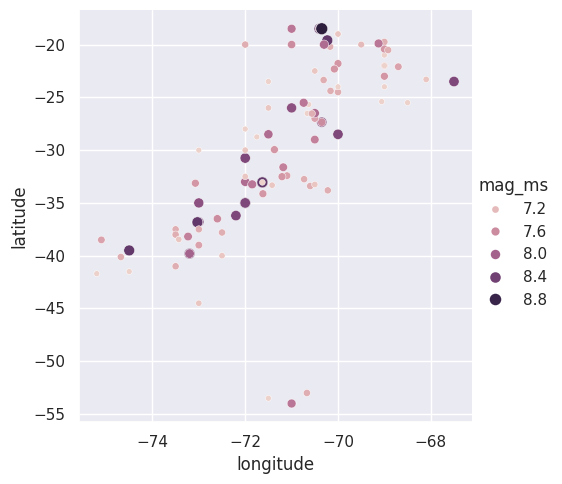

In [36]:
g2 = sns.relplot(x='longitude', y='latitude', data=df, kind='scatter', size='mag_ms', hue='mag_ms')

plt.show()

Para se parecer com a habitual projeção do mapa mundial de Mercator, precisaríamos redimensionar o eixo e fazer uma sobreposição com o território do Chile. É mais fácil usar o fólio da biblioteca para criar um mapa com a distribuição dos principais terremotos no Chile. Vamos gerar um mapa interativo de todos os principais eventos desde 1950 em que a magnitude Ms foi registrada.

In [37]:
events_locations = df[(df['year'] > 1950) & ~(df['mag_ms'].isna())][['latitude','longitude','mag_ms','year']]
map = folium.Map(location=[events_locations.latitude.mean(), events_locations.longitude.mean()], zoom_start=5, control_scale=True)
for index, location_info in events_locations.iterrows():
    popup_text = 'Year: '+str(int(location_info['year'])) +'\nMagnitude Ms: '+str(location_info['mag_ms'])
    folium.Marker([location_info["latitude"], location_info["longitude"]],\
                 popup=popup_text).add_to(map)
map

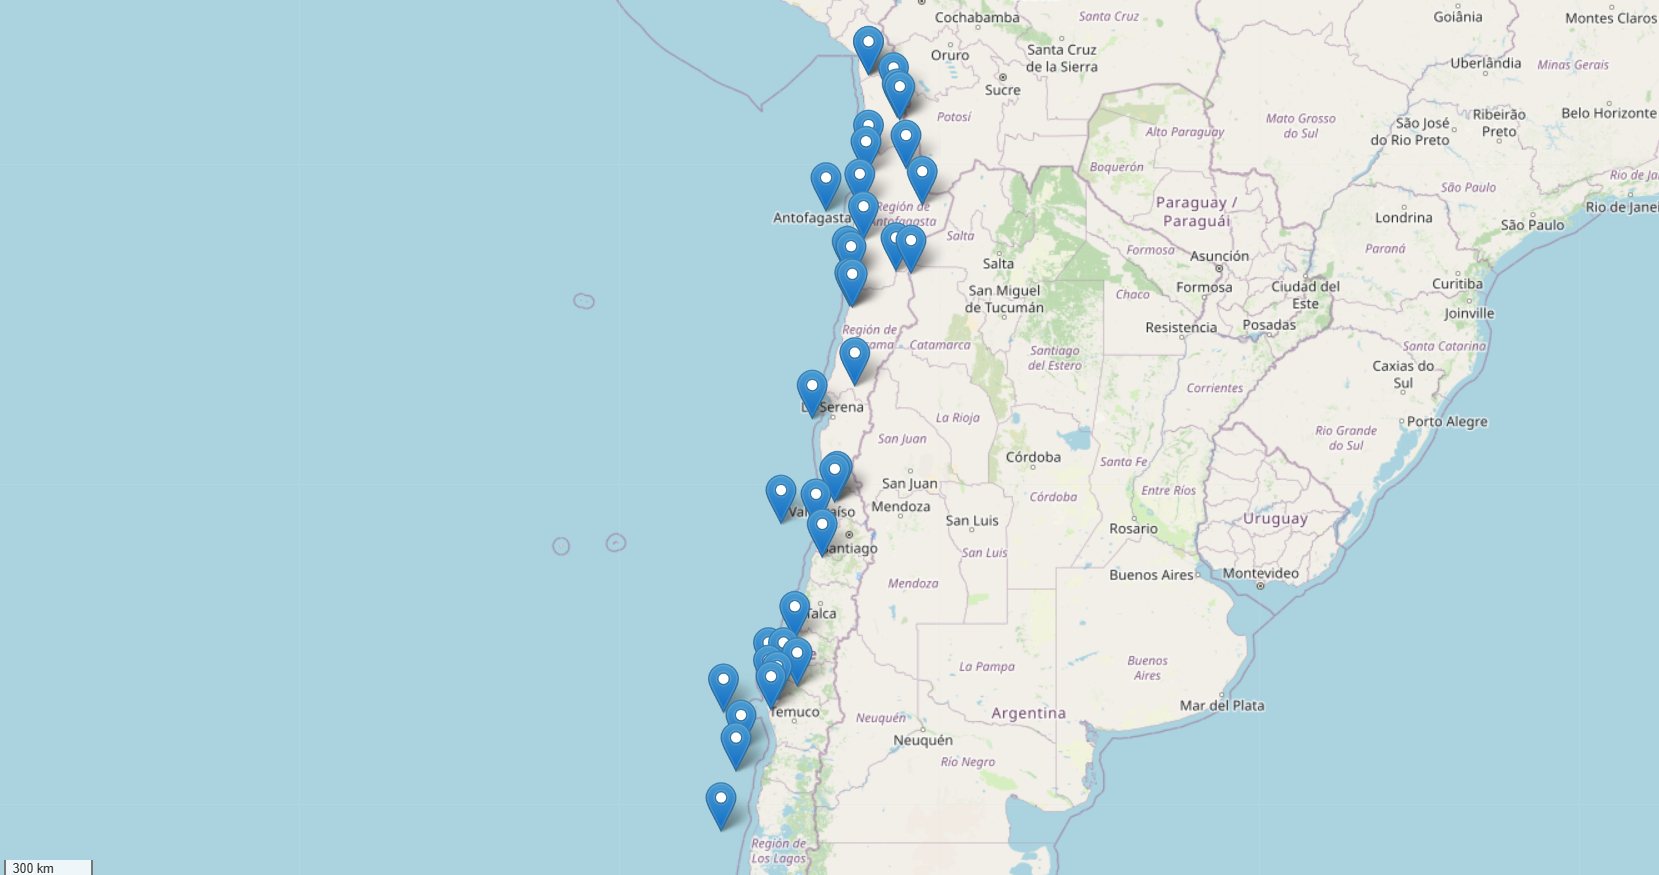

In [48]:
from PIL import Image
#Abrir o mapa pre carregado em png
pilImage = Image.open("mapa png.png")
pilImage

Por fim, só por curiosidade, vejamos todos os principais acontecimentos de 1960, ano do maior terremoto registrado na história, que quase destruiu a cidade de Valdivia, no sul do Chile.

In [45]:
df_clean[df_clean['year'] == 1960]

,date,time,latitude,longitude,mag_ms,mag_mw,depth_km,effect,year,month,day
80,21/05/1960,6:02,-37.5,-73.5,7.3,NaN,NaN,NaN,1960,5,21
81,22/05/1960,6:32,-37.5,-73.0,7.3,NaN,NaN,NaN,1960,5,22
82,22/05/1960,15:11,-39.5,-74.5,8.5,9.5,NaN,TD,1960,5,22
83,19/06/1960,22:01,-38.0,-73.5,7.3,NaN,NaN,NaN,1960,6,19
84,01/11/1960,4:45,-38.5,-75.1,7.4,NaN,55.0,NaN,1960,11,1
